## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2020)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

Tutors: Nicholas James, Songhua Wu, Xuefeng Li, Yu Yao.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 0. Load Modules

In [8]:
# Define your functions in organised individual python files. Don't throw them randomly in the notebook

## Import image processing modules
import os
import numpy as np
from PIL import Image

from utils.misc import load_data, load_data_AR

## Import Algorithms
from algs import nmf_l2

## 1. Load Dataset

### 1.0 Data Folder

In [2]:
# The structure of data folder.
!ls -l data

total 0
drwxr-xr-x 41 Dovermore staff 1312 Oct  6 14:04 CroppedYaleB
drwxr-xr-x 44 Dovermore staff 1408 Oct  6 14:04 ORL


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=2)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (2576, 400), Y.shape = (400,)
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


### 1.2 Load AR Dataset (Optional) 
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [4]:
# X, Y = load_data_AR(root='data/CroppedAR', reduce=3)
# print('AR dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

---------------------------


## 2. Evaluation Metrics


### 2.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


==> Load ORL dataset ...
V_hat.shape=(1110, 400), Y_hat.shape=(400,)


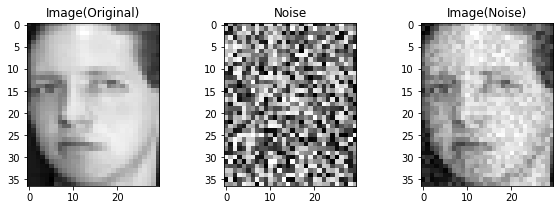

==> Apply NMF ...
W.shape=(1110, 40), H.shape=(40, 400)
==> Evaluate RRE ...
RRE = 0.20648117468621124


In [5]:
# Load dataset.
print('==> Load ORL dataset ...')
V_hat, Y_hat = load_data('data/ORL', reduce=3)
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

# Add Noise.
V_noise = np.random.rand(*V_hat.shape) * 40
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

# TODO: you should implement NMF algorithms by yourself.
print('==> Apply NMF ...')
from sklearn.decomposition import NMF
model = NMF(n_components=len(set(Y_hat))) # set n_components to num_classes.
W = model.fit_transform(V)
H = model.components_
print('W.shape={}, H.shape={}'.format(W.shape, H.shape))

# Evaluate relative reconstruction errors.
print('==> Evaluate RRE ...')
RRE = np.linalg.norm(V_hat - W.dot(H)) / np.linalg.norm(V_hat)
print('RRE = {}'.format(RRE))

### 2.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [6]:
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

print('==> Evaluate Acc and NMI ...')

# Assign cluster labels.
Y_pred = assign_cluster_label(H.T, Y_hat)

acc = accuracy_score(Y_hat, Y_pred)
nmi = normalized_mutual_info_score(Y_hat, Y_pred)
print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))


==> Evaluate Acc and NMI ...
Acc(NMI) = 0.7050 (0.8280)
